In [29]:
import numpy as np
import matplotlib.pylab as plt
import math as math
from scipy.optimize import fmin
from iminuit import Minuit, describe, Struct
from scipy.spatial import distance
from scipy.sparse import vstack
import time
import seaborn as sns
%matplotlib  notebook

In [2]:
def nn(data0,data1,r=None,nneighbors=None):
    ret = -1
    ret_list=[]
    if r is not None and nneighbors is not None:
        exit(-1)
        return ret
    elif r is not None and nneighbors is None:
        rsq = r*r
        for d in data0.transpose():
            count=0
            diffx=d[0]-data1[0]
            diffy=d[1]-data1[1]
            diff= diffx*diffx + diffy*diffy
            count = len(diff[diff<rsq])
            ret_list.append(float(count)/(float(len(data1[0]))*r))
        ret_list = np.array(ret_list)
        return ret_list
    elif r is None and nneighbors is not None:
        for num0 in data0:
            diff = np.abs(num0 - data1)
            diff.sort()
            radius= diff[nneighbors-1]
            ret_list.append(1/radius)
        ret_list = np.array(ret_list)
        return ret_list
    return ret

In [3]:
# Add code to the following function so that it takes in two datasets, loops over one of them, and finds
# information about the nearest neighbors in the other dataset, based on a flag. 

def nncdist(data0,data1,r=None,nneighbors=None):   
    ret = -1
    ret_list=[]
    if r is not None and nneighbors is not None:
        exit(-1)
        return ret
    elif r is not None and nneighbors is None:
        combined = data0.transpose()
        combined1 = data1.transpose()
        dist=distance.cdist(combined,combined1,'euclidean')
        for num in dist:
            count=len(num[num<r])
            ret_list.append(float(count)/(float(len(data1[0]))*r))
        ret_list = np.array(ret_list)
        return ret_list
    elif r is None and nneighbors is not None:
        for num0 in data0:
            diff = np.abs(num0 - data1)
            diff.sort()
            radius= diff[nneighbors-1]
            ret_list.append(1/radius)
        ret_list = np.array(ret_list)
        return ret_list
    return ret

In [4]:
def normal(x,mean,width):
    return (1.0/(width*np.sqrt(2*np.pi)))*(np.exp(-(x-mean)**2/(2*(width**2))))

# A product of two Gaussians
def signal_2D(npts,means,sigmas):
    pts = []
    for m,s in zip(means,sigmas):
        pts.append(np.random.normal(m,s,npts))
    pts = np.array(pts)
    return pts

# Flat in 2D
def background_2D(npts,lovals,hivals):
    pts = []
    for lo,hi in zip(lovals,hivals):
        width = hi-lo
        pts.append(lo + width*np.random.random(npts))
    pts = np.array(pts)
    return pts

# Helper function to generate signal and background at the same time
def gen_sig_and_bkg(npts,means,sigmas,lovals,hivals):
    sigpts = signal_2D(npts[0],means,sigmas)
    bkgpts = background_2D(npts[1],lovals,hivals)
    data = [sigpts[0].copy(),sigpts[1].copy()]
    data[0] = np.append(data[0],bkgpts[0])
    data[1] = np.append(data[1],bkgpts[1])
    data = np.array(data)
    return data

In [5]:
# Test the tools to generate the datasets.
sigpts = signal_2D(3000,[5.0,7.0],[0.1,0.1])
#sns.jointplot(sigpts[0],sigpts[1],kind='hex')
bkgpts = background_2D(10000,[3.5,5],[6,9])
#sns.jointplot(bkgpts[0],bkgpts[1],kind='hex')
data1 = [sigpts[0].copy(),sigpts[1].copy()]
data1[0] = np.append(data1[0],bkgpts[0])
data1[1] = np.append(data1[1],bkgpts[1])
data1 = np.array(data1)
#sns.jointplot(data[0],data[1],kind='hex')

In [65]:

nbkg = 1000
sigmeans = [5.0,7.0]
bkglos = [3.5,5]
bkghis = [6,9]

def calc_pull(iterations, nsig, nMC, rad,cdist_bool,sigwidths):
    
    pull_frac_list=[]
    average_best_frac = 0
    frac = []
    fit_frac = []
    fit_frac_uncert = []
    frac_org = nsig/float(nsig+nbkg)

    for num in range(iterations):
        
        nsig_iteration = np.random.poisson(nsig)
        nbkg_iteration = np.random.poisson(nbkg)
        data = gen_sig_and_bkg([nsig_iteration,nbkg_iteration],sigmeans,sigwidths,bkglos,bkghis)
        signal_points= signal_2D(nMC,sigmeans,sigwidths)
        background_points = background_2D(nMC,bkglos,bkghis)
        frac_iteration = float(nsig_iteration)/(float(nbkg_iteration+nsig_iteration))
        frac.append(frac_iteration)
        
        if cdist_bool:
            signal_prob=nncdist(data,signal_points, r=rad)
            background_prob= nncdist(data,background_points, r=rad)
        else:
            signal_prob=nn(data,signal_points, r=rad)
            background_prob = nn(data,background_points, r=rad)

        def tot_prob(frac):
            tot_prob=[]
            tot_prob.append(frac*signal_prob + ((1-frac)*background_prob))
            return np.array(tot_prob)
        
        def probability(frac):
            prob=tot_prob(frac)
            return -np.log(prob[prob>0]).sum()
        
        m1=Minuit(probability,frac= 0.2,limit_frac=(0.001,1),error_frac=0.001,errordef = 0.5,print_level=0)
        m1.migrad()

        if (m1.get_fmin().is_valid):
            param=m1.values
            err=m1.errors
            fit_frac.append(param["frac"])
            fit_frac_uncert.append(err["frac"])
            pull_frac=(frac_org-param["frac"])/err["frac"]
            pull_frac_list.append(pull_frac)
            
    return pull_frac_list, frac, fit_frac, fit_frac_uncert,iterations

In [7]:
#200 signal points 
#100 iterations
#pythagorean method

means=[]
stds=[]

sig_widths = [0.6,0.6]

pulls_list ={}
for sig in [200]:
    for MC in [10000,100000]:
        start = time.time()
        for rad in [0.01,0.05,0.1,0.15,0.20]: #, 0.10,0.20,0.50]:
            start = time.time()
            print 'number of signal points: %s \t number of MC point: %s \tradius: %s' % (sig,MC,rad)
            pulls,org_vals,fit_vals,fit_uncerts,iteration = calc_pull(100, sig, MC, rad,False,sig_widths)
            name='MC' +str(MC) + 'rad'+str(rad)
            pulls_list[name]=pulls
            
            parameters_mean = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean pulls': np.mean(pulls)}
            means.append(parameters_mean)
            parameters_std = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean stds': np.std(pulls)}
            stds.append(parameters_std)
            print "time to calc 10 iterations: %f s" % (time.time() - start)
print means
print stds
print '--------------------'


number of signal points: 200 	 number of MC point: 10000 	radius: 0.01
time to calc 10 iterations: 10.226464 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.05
time to calc 10 iterations: 10.647519 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.1
time to calc 10 iterations: 10.996473 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.15
time to calc 10 iterations: 11.060784 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.2
time to calc 10 iterations: 10.636613 s
number of signal points: 200 	 number of MC point: 100000 	radius: 0.01
time to calc 10 iterations: 109.009819 s
number of signal points: 200 	 number of MC point: 100000 	radius: 0.05
time to calc 10 iterations: 116.195274 s
number of signal points: 200 	 number of MC point: 100000 	radius: 0.1
time to calc 10 iterations: 121.057960 s
number of signal points: 200 	 number of MC point: 100000 	radius: 0.15
time to calc 10 iterations: 119.16614

In [10]:
for item in means:
    if item['MC_points']==10000:
        print item['mean pulls']

-11.7387503564
-0.147645067841
-0.325386942498
-0.753831487856
-0.956279014934


<IPython.core.display.Javascript object>


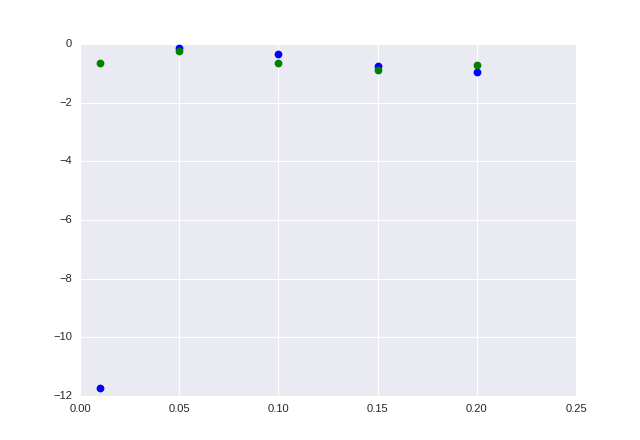

<IPython.core.display.Javascript object>


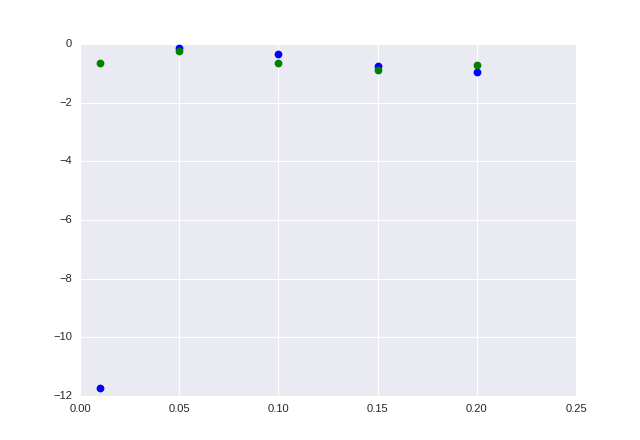

<IPython.core.display.Javascript object>


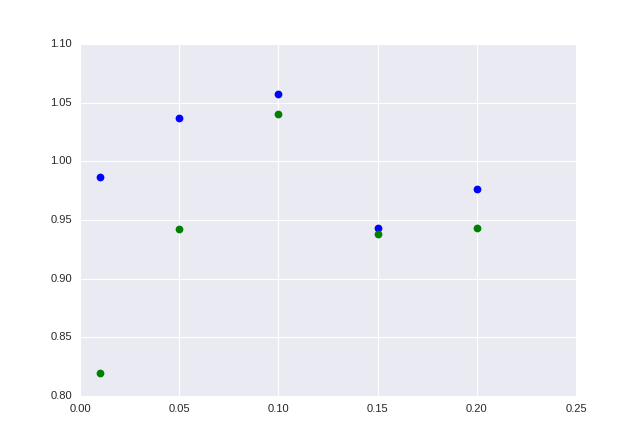

In [28]:
plt.figure()
for item in means:
    if item['MC_points']==10000:
        plt.plot(item['radius'],item['mean pulls'], 'bo')
    else:
        plt.plot(item['radius'],item['mean pulls'], 'go')
#plt.ylim(-1,.1)
#plt.ylim(-.5,.5)
plt.figure()
for item in means:
    if item['MC_points']==10000:
        plt.plot(item['radius'],item['mean pulls'], 'bo')
    else:
        plt.plot(item['radius'],item['mean pulls'], 'go')
#plt.ylim(-2,.1)

plt.figure()
for item in stds:
    if item['MC_points']==10000:
        plt.plot(item['radius'],item['mean stds'], 'bo')
    else:
        plt.plot(item['radius'],item['mean stds'], 'go')
#plt.xlim(0,.15)

In [ ]:

plt.figure()
plt.hist(pulls_list['MC100000rad0.1'],bins=30)
x = np.arange(-5,5,0.1)
y = 18*normal(x,0.0,1.0)
plt.plot(x,y)

In [13]:
#signal points 200
#cdist method
#100 iterations

means_cdist=[]
stds_cdist=[]
sig_widths = [0.6,0.6]

pulls_list ={}
for sig in [200]:
    for MC in [10000,100000]:
        for rad in [0.01,0.05,0.1,0.15,0.20]: #, 0.10,0.20,0.50]:
            print 'number of signal points: %s \t number of MC point: %s \tradius: %s' % (sig,MC,rad)
            start=time.time()
            pulls_cdist,org_vals_cdist,fit_vals_cdist,fit_uncerts_cdist,iteration_cdist = calc_pull(100, sig, MC, rad,True,sig_widths)
            parameters_mean_cdist = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean pulls': np.mean(pulls_cdist)}
            means_cdist.append(parameters_mean_cdist)
            parameters_std_cdist = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean stds': np.std(pulls_cdist)}
            stds_cdist.append(parameters_std_cdist)
            print "time to calc 10 iterations: %f s" % (time.time() - start)
            
            

print means_cdist
print stds_cdist
print '--------------------'


number of signal points: 200 	 number of MC point: 10000 	radius: 0.01
time to calc 10 iterations: 16.405069 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.05
time to calc 10 iterations: 17.006199 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.1
time to calc 10 iterations: 17.434594 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.15
time to calc 10 iterations: 17.349785 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.2
time to calc 10 iterations: 17.376570 s
number of signal points: 200 	 number of MC point: 100000 	radius: 0.01
time to calc 10 iterations: 155.075093 s
number of signal points: 200 	 number of MC point: 100000 	radius: 0.05
time to calc 10 iterations: 162.314151 s
number of signal points: 200 	 number of MC point: 100000 	radius: 0.1
time to calc 10 iterations: 166.256289 s
number of signal points: 200 	 number of MC point: 100000 	radius: 0.15
time to calc 10 iterations: 165.01241

<IPython.core.display.Javascript object>


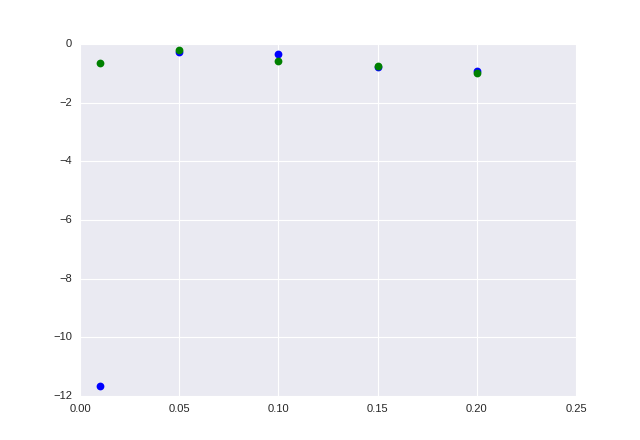

<IPython.core.display.Javascript object>


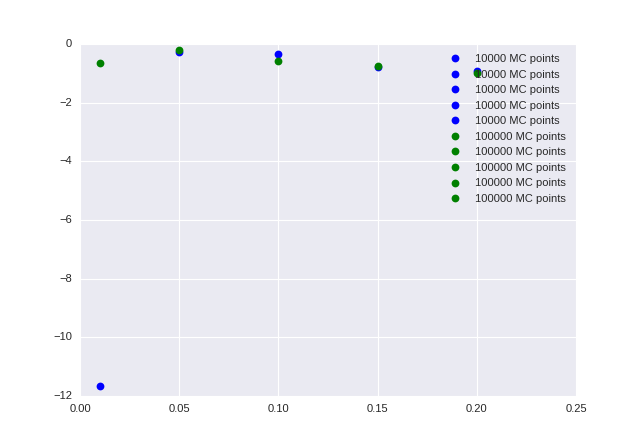

<IPython.core.display.Javascript object>


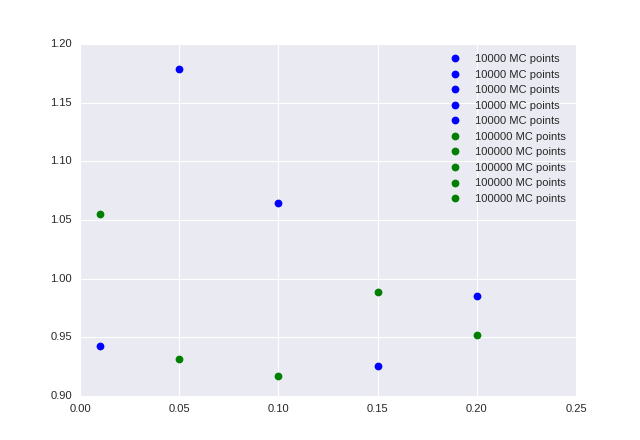

In [31]:
plt.figure()
for item in means_cdist:
    if item['MC_points']==10000:
        blue=plt.plot(item['radius'],item['mean pulls'], 'bo',label='10000 MC points')
    else:
        green=plt.plot(item['radius'],item['mean pulls'], 'go',label='100000 MC points')
plt.legend([],['10000 MC points','100000 MC points'])
plt.show()

#plt.ylim(-1,.1)
#plt.ylim(-.5,.5)
plt.figure()
for item in means_cdist:
    if item['MC_points']==10000:
        plt.plot(item['radius'],item['mean pulls'], 'bo',label='10000 MC points')
    else:
        plt.plot(item['radius'],item['mean pulls'], 'go',label='100000 MC points')
#plt.ylim(-2,.1)
plt.legend()

plt.figure()
for item in stds_cdist:
    if item['MC_points']==10000:
        plt.plot(item['radius'],item['mean stds'], 'bo',label='10000 MC points')
    else:
        plt.plot(item['radius'],item['mean stds'], 'go',label='100000 MC points')
#plt.xlim(0,.15)
plt.legend()

In [187]:

#pythagorean method
means800=[]
stds800=[]

sig_list=[200,400]
MC_list=[10000,100000]
rad_list=[0.05,0.1,0.15,0.20]
width_list=[0.06,.15]

pulls_list ={}
for sig in sig_list:
    for MC in MC_list: #,100000]:
        start = time.time()
        for rad in rad_list:#,0.05,0.1,0.15,0.20]: #, 0.10,0.20,0.50]:
            for w in width_list:
                sign_widths=[w,w]
                start = time.time()
                print 'number of signal points: %s \t number of MC point: %s \tradius: %s \t width: %s' % (sig,MC,rad,w)
                pulls,org_vals1,fit_vals1,fit_uncerts1,iteration= calc_pull(1000, sig, MC, rad,False,sig_widths)
                name='MC' +str(MC) + 'rad'+str(rad)
                pulls_list[name]=pulls

                parameters_mean = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean pulls': np.mean(pulls), 'width':w}
                means800.append(parameters_mean)
                parameters_std = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean stds': np.std(pulls),'width':w}
                stds800.append(parameters_std)
                print "time to calc 10 iterations: %f s" % (time.time() - start)        

print means800
print stds800
print '--------------------'



number of signal points: 200 	 number of MC point: 10000 	radius: 0.05 	 width: 0.06
time to calc 10 iterations: 101.726896 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.05 	 width: 0.15
time to calc 10 iterations: 92.488842 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.1 	 width: 0.06
time to calc 10 iterations: 95.183987 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.1 	 width: 0.15
time to calc 10 iterations: 96.249923 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.15 	 width: 0.06
time to calc 10 iterations: 98.612083 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.15 	 width: 0.15
time to calc 10 iterations: 98.453880 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.2 	 width: 0.06
time to calc 10 iterations: 102.086336 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.2 	 width: 0.15
time to calc 10 iterations: 102.365587 s
n

<IPython.core.display.Javascript object>


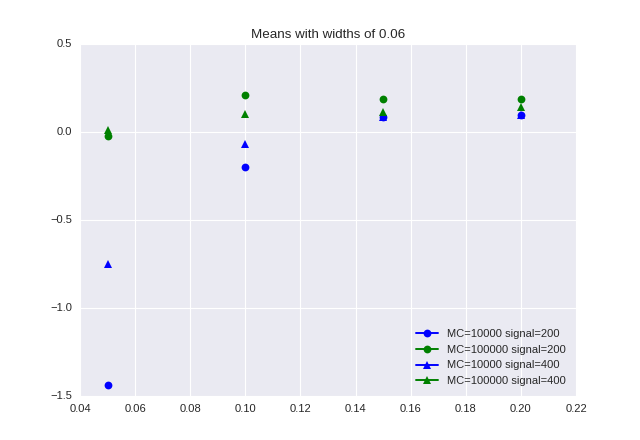

<IPython.core.display.Javascript object>


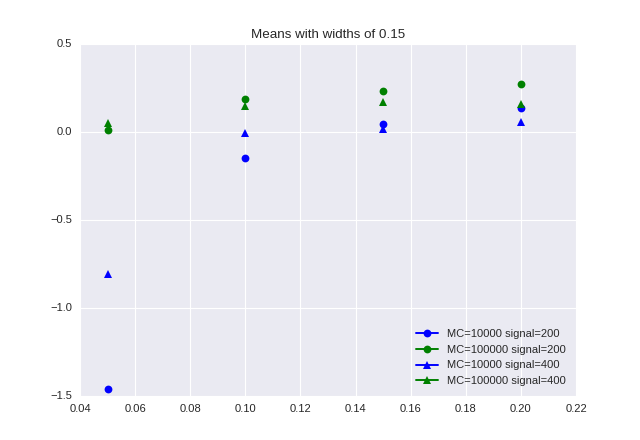

<IPython.core.display.Javascript object>


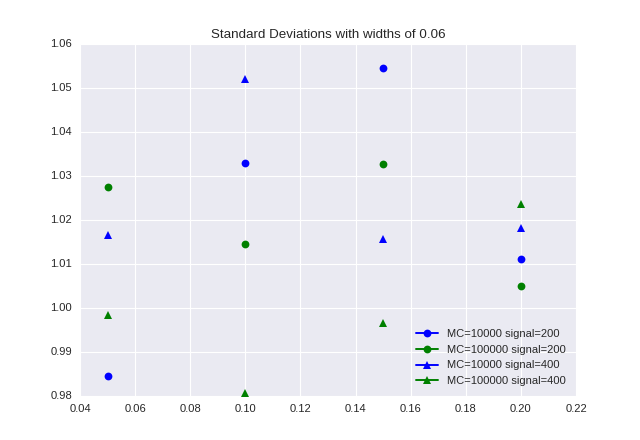

<IPython.core.display.Javascript object>


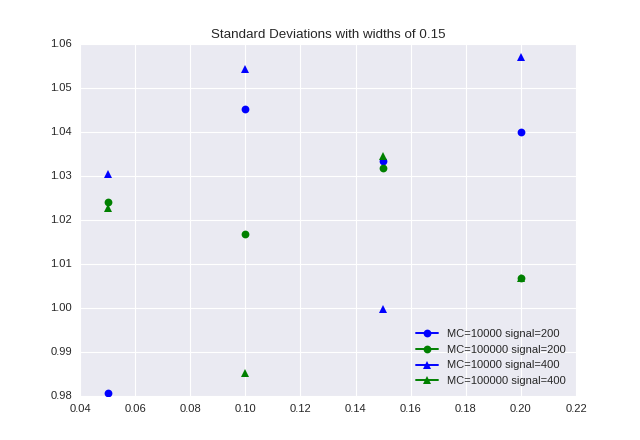

In [193]:
plt.figure()
colors=['b','g','y','r']
markers=['o','^','+']
marker_sizes=[5,10,60]
labels=[]

for item in means800:
    if item['width']==width_list[0]:
        label='MC=' + str(item['MC_points']) + ' signal=' + str(item['signal'])
    
        if item['MC_points']== MC_list[0]:
            color=colors[0]
        if item['MC_points']==MC_list[1]:
            color=colors[1]

        if item['signal']==sig_list[0]:
            marker=markers[0]
        if item['signal']==sig_list[1]:
            marker=markers[1]

        for x in labels:
            if label==x:
                label=""

        plt.plot(item['radius'],item['mean pulls'], color=color, marker=marker,label=label)
    labels.append(label)

plt.legend(loc='lower right')
plt.title("Means with widths of "+str(width_list[0]))
plt.savefig('means_with_widths_0.06.png')
           
plt.figure()
labels=[]
           
for item in means800:
    if item['width']==width_list[1]:
        label='MC=' + str(item['MC_points']) +  ' signal=' + str(item['signal'])
    
        if item['MC_points']== MC_list[0]:
            color=colors[0]
        if item['MC_points']==MC_list[1]:
            color=colors[1]

        if item['signal']==sig_list[0]:
            marker=markers[0]
        if item['signal']==sig_list[1]:
            marker=markers[1]

        for x in labels:
            if label==x:
                label=""

        plt.plot(item['radius'],item['mean pulls'], color=color, marker=marker,label=label)
        labels.append(label)

plt.legend(loc='lower right')    

plt.title("Means with widths of "+str(width_list[1]))
plt.savefig('means_with_widths_0.15.png')


plt.figure()
labels=[]
           
for item in stds800:
    if item['width']==width_list[0]:
        label='MC=' + str(item['MC_points']) +  ' signal=' + str(item['signal'])
    
        if item['MC_points']== MC_list[0]:
            color=colors[0]
        if item['MC_points']==MC_list[1]:
            color=colors[1]

        if item['signal']==sig_list[0]:
            marker=markers[0]
        if item['signal']==sig_list[1]:
            marker=markers[1]

        for x in labels:
            if label==x:
                label=""

        plt.plot(item['radius'],item['mean stds'], color=color, marker=marker,label=label)
        labels.append(label)

plt.legend(loc='lower right')   

plt.title("Standard Deviations with widths of "+str(width_list[0]))
plt.savefig('stds_with_widths_0.06.png')




plt.figure()
labels=[]
           
for item in stds800:
    if item['width']==width_list[1]:
        label='MC=' + str(item['MC_points']) +  ' signal=' + str(item['signal'])
    
        if item['MC_points']== MC_list[0]:
            color=colors[0]
        if item['MC_points']==MC_list[1]:
            color=colors[1]

        if item['signal']==sig_list[0]:
            marker=markers[0]
        if item['signal']==sig_list[1]:
            marker=markers[1]

        for x in labels:
            if label==x:
                label=""

        plt.plot(item['radius'],item['mean stds'], color=color, marker=marker,label=label)
        labels.append(label)

plt.legend(loc='lower right')

plt.title("Standard Deviations with widths of "+str(width_list[1]))
plt.savefig('stds_with_widths_0.15.png')


In [125]:
#800 signal points
#pythagorean method
means800=[]
stds800=[]

#sig_widths = [0.6,0.6]
sig_list=[200,400]
MC_list=[10000,100000]
rad_list=[0.01,0.05,0.1,0.15,0.20]
width_list=[0.06,.15]

pulls_list ={}
for sig in sig_list:
    for MC in MC_list: #,100000]:
        start = time.time()
        for rad in rad_list:#,0.05,0.1,0.15,0.20]: #, 0.10,0.20,0.50]:
            for w in width_list:
                sign_widths=[w,w]
                start = time.time()
                print 'number of signal points: %s \t number of MC point: %s \tradius: %s \t width: %s' % (sig,MC,rad,w)
                pulls,org_vals1,fit_vals1,fit_uncerts1,iteration= calc_pull(10, sig, MC, rad,False,sig_widths)
                name='MC' +str(MC) + 'rad'+str(rad)
                pulls_list[name]=pulls

                parameters_mean = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean pulls': np.mean(pulls), 'width':w}
                means800.append(parameters_mean)
                parameters_std = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean stds': np.std(pulls),'width':w}
                stds800.append(parameters_std)
                print "time to calc 10 iterations: %f s" % (time.time() - start)        

print means800
print stds800
print '--------------------'



number of signal points: 200 	 number of MC point: 10000 	radius: 0.01 	 width: 0.06
time to calc 10 iterations: 0.938094 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.01 	 width: 0.15
time to calc 10 iterations: 0.917374 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.05 	 width: 0.06
time to calc 10 iterations: 0.937858 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.05 	 width: 0.15
time to calc 10 iterations: 0.956699 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.1 	 width: 0.06
time to calc 10 iterations: 0.972548 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.1 	 width: 0.15
time to calc 10 iterations: 0.939491 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.15 	 width: 0.06
time to calc 10 iterations: 0.977794 s
number of signal points: 200 	 number of MC point: 10000 	radius: 0.15 	 width: 0.15
time to calc 10 iterations: 0.993756 s
number of 

<IPython.core.display.Javascript object>


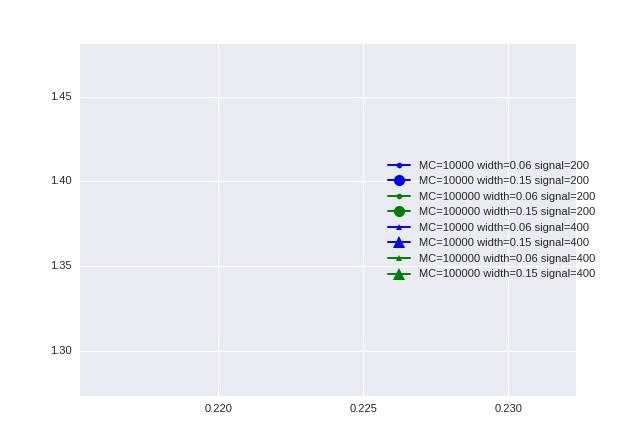

<IPython.core.display.Javascript object>


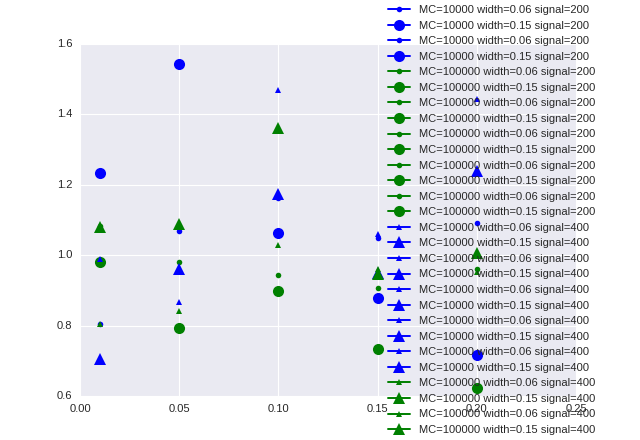

In [152]:
plt.figure()
colors=['b','g','y','r']
markers=['o','^','+']
marker_sizes=[5,10,60]
labels=[]

for item in means800:
    label='MC=' + str(item['MC_points']) + ' width='+str(item['width'])+ ' signal=' + str(item['signal'])
    if item['MC_points']== MC_list[0]:
        color=colors[0]
    if item['MC_points']==MC_list[1]:
        color=colors[1]
        
    if item['signal']==sig_list[0]:
        marker=markers[0]
    if item['signal']==sig_list[1]:
        marker=markers[1]
        
    if item['width']==width_list[0]:
        marker_size=marker_sizes[0]
    if item['width']==width_list[1]:
        marker_size=marker_sizes[1]
        
    for x in labels:
        if label==x:
            label=""
            
    plt.plot(item['radius'],item['mean pulls'], color=color, marker=marker,markersize=marker_size,label=label)
    labels.append(label)

plt.legend(loc='center left', bbox_to_anchor=(0.6,0.5))
#plt.ylim(-1,.1)
#plt.ylim(-.5,.5)
labels=[]

plt.figure()
for item in stds800:
    label='MC=' + str(item['MC_points']) + ' width='+str(item['width'])+ ' signal=' + str(item['signal'])
    if item['MC_points']== MC_list[0]:
        color=colors[0]
    if item['MC_points']==MC_list[1]:
        color=colors[1]
    if item['signal']==sig_list[0]:
        marker=markers[0]
    if item['signal']==sig_list[1]:
        marker=markers[1]
    if item['width']==width_list[0]:
        marker_size=marker_sizes[0]
    if item['width']==width_list[1]:
        marker_size=marker_sizes[1]
    for x in labels:
        if label==x:
            label=""
            
    plt.plot(item['radius'],item['mean stds'], color=color, marker=marker,markersize=marker_size,label=label)
labels.append(label)

plt.legend(loc='center left', bbox_to_anchor=(0.6,0.5))
#plt.xlim(0,.15)

In [ ]:
#400 signal
#cdist method

means_cdist_400=[]
stds_cdist_400=[]

sig_widths = [1.5,1.5]

pulls_list ={}
for sig in [800]:
    for MC in [1000,10000,100000]:
        #start = time.time()
        for rad in [0.01,0.05,0.1,0.15,0.20]: #, 0.10,0.20,0.50]:
            print 'number of signal points: %s \t number of MC point: %s \tradius: %s' % (sig,MC,rad)
            start=time.time()
            pulls_cdist,org_vals_cdist,fit_vals_cdist,fit_uncerts_cdist,iteration_cdist = calc_pull(1000, sig, MC, rad,True,sig_widths)
            parameters_mean_cdist = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean pulls': np.mean(pulls_cdist)}
            means_cdist_400.append(parameters_mean_cdist)
            parameters_std_cdist = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean stds': np.std(pulls_cdist)}
            stds_cdist_400.append(parameters_std_cdist)
            print "time to calc 10 iterations: %f s" % (time.time() - start)
            
            

print means_cdist_400
print stds_cdist_400
print '--------------------'
#800 signal
#cdist method

In [ ]:
plt.figure()
for item in means:
    if item['MC_points']==10000:
        plt.plot(item['radius'],item['mean pulls'], 'bo',label='10000 MC points')
    else:
        plt.plot(item['radius'],item['mean pulls'], 'go',label='100000 MC points')
#plt.ylim(-2,.1)
plt.legend()
#plt.ylim(-1,.1)
#plt.ylim(-.5,.5)
plt.figure()
for item in means:
    if item['MC_points']==10000:
        plt.plot(item['radius'],item['mean pulls'], 'bo',label='10000 MC points')
    else:
        plt.plot(item['radius'],item['mean pulls'], 'go',label='100000 MC points')
#plt.ylim(-2,.1)
plt.legend()
#plt.ylim(-2,.1)

plt.figure()
for item in stds:
    if item['MC_points']==10000:
        plt.plot(item['radius'],item['mean pulls'], 'bo',label='10000 MC points')
    else:
        plt.plot(item['radius'],item['mean pulls'], 'go',label='100000 MC points')
#plt.ylim(-2,.1)
plt.legend()
#plt.xlim(0,.15)